Notebook notes: this notebook is evaluating the test set from the Open Cities AI dataset and seeing how good the model used for transfer learning is

In [1]:
%load_ext autoreload
%autoreload 2
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import sys
sys.path.insert(0, '../models')
from unet_model import UNet
sys.path.insert(0, '../train')
from training import train_one_epoch, valid_one_epoch
sys.path.insert(0, '../utils')
from driven_dataset import drivenDataset
from metrics import returnInterUnion, returnPreReF
from data_functions import splitDataset, returnLoaders

In [2]:
logdir = '../logs/driven/07_24_driven_lr_0.0003_epochs_40_batch_size_4/'

# Getting Tensorboard Loss Values

In [ ]:
event_acc = EventAccumulator(logdir)
event_acc.Reload()
print(event_acc.Tags())

In [ ]:
_, _, tr_iter_loss = zip(*event_acc.Scalars('Iteration Training Loss'))
_, _, val_iter_loss = zip(*event_acc.Scalars('Iteration Validation Loss'))

In [ ]:
_, _, tr_epoch_loss = zip(*event_acc.Scalars('Epoch Training Loss'))
_, _, val_epoch_loss = zip(*event_acc.Scalars('Epoch Validation Loss'))

In [ ]:
fig = plt.figure(figsize = (8,6), dpi = 120)
plt.plot(list(range(len(tr_epoch_loss))), tr_epoch_loss, label = "Train")
plt.plot(list(range(len(val_epoch_loss))), val_epoch_loss, label = "Valid")
plt.ylabel("Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.title("Training and Validation Loss Curves", fontsize=20)
plt.legend(fontsize = 12)

# Test Set Evaluation

In [26]:
model = UNet(3, 2)
model.load_state_dict(torch.load('../../../saved_models/driven/07_24_driven_lr_0.0003_epochs_40_batch_size_4.pth'))

image_path = '../../../../../datadrive/train/images/'
mask_path = '../../../../../datadrive/train/masks/'
dataset = drivenDataset(image_path, mask_path)
datasets = splitDataset(dataset)
trainloader, validloader, testloader = returnLoaders(datasets, 16, True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_num_batches = len(testloader)
test_num_examples = len(testloader.dataset)

model.to(device)            

#Define loss function
#Weight due to class imbalance
pos_weight = torch.tensor([1, 30]) #23 is good when doing 3 class
pos_weight = torch.reshape(pos_weight,(1,2,1,1)).to(device)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,
                                     weight_decay = 1e-7)

In [27]:
example = next(iter(testloader))
inputs = example[0]
labels = example[1]

(-0.5, 1023.5, 1023.5, -0.5)

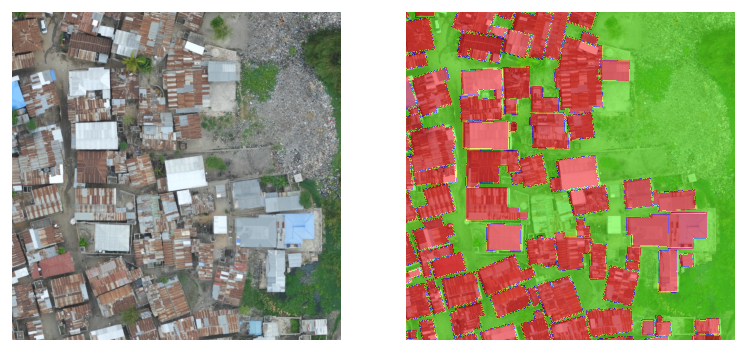

In [30]:
i = 12
kwarg_dict = { 'BACKGROUND':{'cmap':'prism', 'alpha': 0.5},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'CAFO Shed': {'cmap':'hot', 'alpha': 0.0}}

f = plt.figure(figsize=(12,8), dpi=120)
a= f.add_subplot(1, 3, 1)    
changedInput = (inputs[i].permute(1, 2, 0).numpy() * 255).astype('uint8') 
plt.imshow(changedInput)
plt.axis('off')

a = f.add_subplot(1, 3, 2)
plt.imshow(changedInput)
plt.imshow(labels[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
plt.imshow(labels[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed']) 
plt.axis('off')

In [ ]:
plt.imshow(changedInput)
plt.imshow(predictions_one_hot[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
plt.imshow(predictions_one_hot[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])    

In [ ]:
today = date.today()
date_prefix = today.strftime("%m_%d")
log_dir_suffix = f"{date_prefix}_groundtruth_lr_{3e-4}_epochs_{10}_batch_size_{4}"
log_dir = "../logs/groundtruth/" + log_dir_suffix
writer = SummaryWriter(log_dir=log_dir)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
model.zero_grad()
class_list = [0, 1]

In [ ]:
test_loss = []
test_correct = 0
epoch = 0
conf_matrix = np.zeros((2, 2))

with tqdm(total = test_num_batches) as epoch_pbar:
    model.eval()                           
    test_loss, test_correct, \
        conf_matrix, valid_IoU = valid_one_epoch(epoch, test_num_batches, model, 
                                                 device, testloader, epoch_pbar, 
                                                 optimizer, writer, criterion,
                                                 conf_matrix, class_list)

In [ ]:
conf_matrix[0, 1]/(conf_matrix[0, 1] + conf_matrix[1, 1])

In [ ]:
precision, recall, f_score = returnPreReF(conf_matrix, 1)

In [ ]:
precision

In [ ]:
recall

In [ ]:
f_score

In [ ]:
# Testing it out on validation
val_example = next(iter(testloader))
inputs = val_example[0].to(device)
labels = val_example[1].to(device)
with torch.no_grad():
    outputs = model(inputs)
_, predictions = torch.max(outputs, 1)
predictions_one_hot = torch.nn.functional.one_hot(predictions).permute(0, 3, 1, 2)
y_pred = predictions.flatten().cpu().numpy()
_, blah = torch.max(labels, 1)

y_true = blah.flatten().cpu().numpy()

In [ ]:
kwarg_dict = { 'BACKGROUND':{'cmap':'prism', 'alpha': 0.5},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'CAFO Shed': {'cmap':'hot', 'alpha': 0.0}}

for i in range(4):
    f = plt.figure()
    a= f.add_subplot(1, 3, 1)    
    changedInput = (inputs[i].permute(1, 2, 0).cpu().numpy() * 255).astype('uint8') 
    plt.imshow(changedInput)
    if labels != None:
        plt.imshow(labels[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
        plt.imshow(labels[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed']) 
    plt.axis('off')

    a = f.add_subplot(1, 3, 2)
    plt.imshow(changedInput)
    plt.imshow(predictions_one_hot[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(predictions_one_hot[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])    
    plt.axis('off')